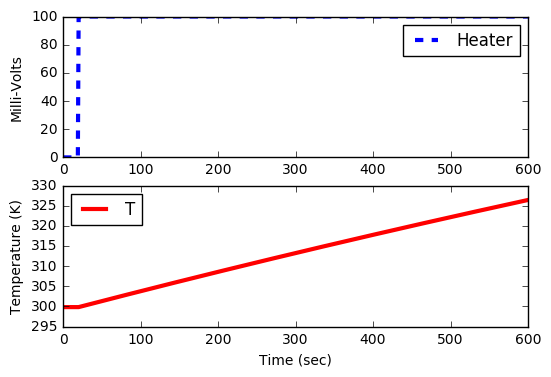

In [2]:
# Step 1 Simulate Temperature Response

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# define Arduino model
def arduino(x,t,mV,Ta):
    ## parameters
    h = 1.0    # heat transfer coefficient W/m^2-K
    m = 4.0/1000.0  # kg
    Cp = 0.5 * 1000.0  # J/Kg-K
    A = 6.0/100.0**2   # Area in m^2
    Amp = 1.0          # Amps to Transitor
    T = x[0]
    
    # acc = inlet - outlet
    dTdt = (1.0/(m*Cp))*(-h*A*(T-Ta)+Amp*mV/1000.0)
    return dTdt

# Ambient temperature
Ta = (80.0-32.0)*5.0/9.0 + 273.15 # 80 degF in K
# starting temperature
T0 = Ta 

# time intervals (sec)
t = np.linspace(0,600,601)

# manipulated variable
mV = np.ones(len(t))*0.0 # millivolts input
mV[20:] = 100.0
# store results for plotting
T = np.ones(len(t))*T0

for i in range(len(t)-1):
    ts = [t[i],t[i+1]]
    y = odeint(arduino,T0,ts,args = (mV[i],Ta))
    T0 = y[-1]
    T[i+1] = T0

# Construct results and save data file
# Column 1 = time
# Column 2 = voltages
# Column 3 = temperature
data = np.vstack((t,mV,T)) # vertical stack
data = data.T             # transpose data
np.savetxt('data.txt',data,delimiter=',')

# Plot the results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,mV,'b--',linewidth=3)
plt.ylabel('Milli-Volts')
plt.legend(['Heater'],loc='best')

plt.subplot(2,1,2)
plt.plot(t,T,'r-',linewidth=3)
plt.ylabel('Temperature (K)')
plt.legend(['T'],loc='best')

plt.xlabel('Time (sec)')
plt.savefig('step1.png')

plt.show()

Initial SSE Objective: 1.40123658778
Final SSE Objective: 1.40123658778
h: 10.0
m: 0.004
Amp: 1.0

FOPDT Equivalent
Kp: 0.166666666667
taup: 333.333333333


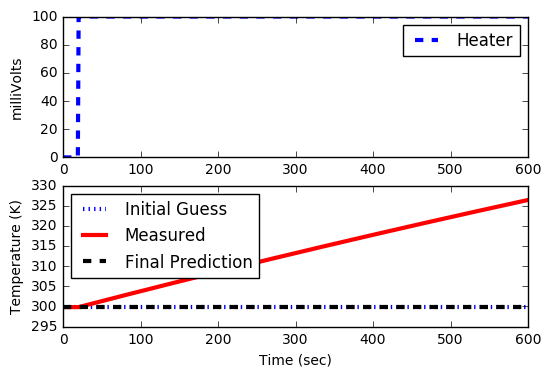

In [6]:
## Step 2 Optimize Model Parameters

import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize

# Import data file
# Column 1 = time (t)
# Column 2 = input (u)
# Column 3 = output (yp)
data = np.loadtxt('data.txt',delimiter=',')
mV0 = data[0,1]
Tmeas0 = data[0,2]
t = data[:,0].T
mV = data[:,1].T
Tmeas = data[:,2].T

# specify number of steps
ns = len(t)
delta_t = t[1]-t[0]

Cp = 0.5*1000.0 # J/kg-K
A = 6.0/100.0**2 # Area in m^2
Ta = Tmeas0

# define arduino model
def arduino(x,t,mVi,p):
    h = p[0]
    m = p[1]
    Amp = p[2]
    
    T = x[0]
    # acc = inlet - outlet
    dTdt = (1.0/(m*Cp))*(-h*A*(T-Ta)+Amp*mVi/1000.0)
    return dTdt

def calc_T(p):
    T = np.ones(len(t))* Tmeas0
    T0 = T[0]
    for i in range(len(t)-1):
        ts = [t[i],t[i+1]]
        y = odeint(arduino,T0,ts,args = (mV[i],p))
        T0 = y[-1]
        T[i+1] = T0
        return T

# define objective
def objective(p):
    # simulate model
    Tp = calc_T(p)
    obj = 0.0
    for i in range(len(Tmeas)):
        obj = obj + ((Tp[i]-Tmeas[i])/Tmeas[i])**2
    return obj

# Parameter initial guess
h = 10.0               # W/m^2-K
m = 4.0/1000.0         # kg
Amp = 1.0              # Amps to transistor
p0 = [h,m,Amp]

# show initial objective
print('Initial SSE Objective: ' + str(objective(p0)))

# optimize parameters
# bounds on variables
bnds = ((1.0, 20.0),(1.0/1000.0,10.0/1000.0),(0.5,2.0))
solution = minimize(objective,p0,method='SLSQP',bounds=bnds)
p = solution.x

# show final objective
print('Final SSE Objective: ' + str(objective(p)))

h = p[0]
m = p[1]
Amp = p[2]
print('h: ' + str(h))
print('m: ' + str(m))
print('Amp: ' + str(Amp))

print('')
print('FOPDT Equivalent')
#dx/dt = (-1/taup) * x + (Kp/taup) * u
#dTdt = (1.0/(m*Cp))*(-h*A*(T-Ta) + Amp*mVi/1000.0)
dfdT = -h*A/(m*Cp)
dfdmV = Amp/(1000.0*m*Cp)
taup = -1.0/dfdT
Kp = dfdmV * taup
print('Kp: ' + str(Kp))
print('taup: ' + str(taup))

# calculate model with updated parameters
T1 = calc_T(p0)
T2 = calc_T(p)

# Plot the results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,mV,'b--',linewidth=3)
plt.ylabel('milliVolts')
plt.legend(['Heater'],loc='best')

plt.subplot(2,1,2)
plt.plot(t,T1,'b:',linewidth=3,label='Initial Guess')
plt.plot(t,Tmeas,'r-',linewidth=3,label='Measured')
plt.plot(t,T2,'k--',linewidth=3,label='Final Prediction')
plt.ylabel('Temperature (K)')
plt.legend(loc='best')
plt.xlabel('Time (sec)')
plt.savefig('step2.png')
plt.show()